In [ ]:
#default_exp metrics

In [ ]:
#hide
#missing
!git clone https://github.com/marcomatteo/steel_segmentation.git

In [ ]:
#hide
#missing
!pip install -e steel_segmentation

# Metrics

> A collection of Metrics used in the segmentation models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/05_metrics.ipynb)

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from steel_segmentation.metadata import *
from steel_segmentation.masks import *
from steel_segmentation.datasets import *
from steel_segmentation.dataloaders import *

import fastai
from fastai.vision.all import *
from fastcore.foundation import *

import torch
import torch.nn.functional as F

import segmentation_models_pytorch as smp

In this section there are all the metric that can be used to evaluate the performances of the segmentation models trained.

In [ ]:
# missing
device = torch.device("cpu")
dls = get_segmnt_dls(bs=20, size=(256, 256))
x, targs = dls.train.one_batch()
x.shape, targs.shape

(torch.Size([20, 3, 256, 256]), torch.Size([20, 4, 256, 256]))

In [ ]:
# missing
x = x.cpu()
x.device, targs.device

(device(type='cpu'), device(type='cpu'))

In [ ]:
# missing
model = smp.Unet("resnet18", 
                 encoder_weights="imagenet", 
                 classes=4, 
                 activation=None).to(device)
logits = model(x)
preds = (torch.sigmoid(logits) > 0.5).float()
preds.shape

torch.Size([20, 4, 256, 256])

In [ ]:
#missing
logits.device, preds.device

(device(type='cpu'), device(type='cpu'))

## Multiclass Dice

This code comes from the fastai docs to test properly the metrics:

In [ ]:
#For testing: a fake learner and a metric that isn't an average
@delegates()
class TstLearner(Learner):
    def __init__(self,dls=None,model=None,**kwargs): self.pred,self.xb,self.yb = None,None,None
        
#Go through a fake cycle with various batch sizes and computes the value of met
def compute_val(met, pred, y):
    met.reset()
    vals = [0,6,15,20]
    learn = TstLearner()
    for i in range(3):
        learn.pred = pred[vals[i]:vals[i+1]]
        learn.yb = ( y[vals[i]:vals[i+1]], )
        met.accumulate(learn)
    return met.value

In [ ]:
# export
class ModDiceMulti(Metric):
    "Averaged Dice metric (Macro F1) for multiclass target in segmentation"

    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter, self.union = {}, {}

    def accumulate(self, learn):
        pred = learn.pred.argmax(dim=self.axis)
        y = learn.yb[0]
        
        # Added to deal with 4-channels masks
        if pred.shape != y.shape:
            y = y.argmax(dim=self.axis)
            
        pred, targ = flatten_check(pred, y)
        for c in range(learn.pred.shape[self.axis]):
            p = torch.where(pred == c, 1, 0)
            t = torch.where(targ == c, 1, 0)
            p, t = TensorBase(p), TensorBase(t)
            c_inter = (p*t).float().sum().item()
            c_union = (p+t).float().sum().item()
            if c in self.inter:
                self.inter[c] += c_inter
                self.union[c] += c_union
            else:
                self.inter[c] = c_inter
                self.union[c] = c_union

    @property
    def value(self):
        binary_dice_scores = np.array([])
        for c in self.inter:
            binary_dice_scores = np.append(
                binary_dice_scores, 
                2.*self.inter[c]/self.union[c] if self.union[c] > 0 else np.nan)
        self.binary_dice_scores = binary_dice_scores
        return np.nanmean(binary_dice_scores)

In [ ]:
dice_obj = ModDiceMulti()

In [ ]:
# missing
compute_val(dice_obj, pred=preds, y=targs)

0.2136215772421966

For test purpose, we create a tensor `x1`, as a prediction for the first channel.

In [ ]:
x1a = torch.ones(20,1,1,1)
x1b = torch.clone(x1a)*0.5
x1c = torch.clone(x1a)*0.3
x1d = torch.clone(x1a)*0.1

x1 = torch.cat((x1a,x1b,x1c,x1d),dim=1)   # Prediction: 20x4
x1.shape

torch.Size([20, 4, 1, 1])

When target is a flatten mask, used by fastai segmentation models:

In [ ]:
x2 = torch.zeros(20,1,1)  # Target: 20xClass0
x2.shape

torch.Size([20, 1, 1])

When the target is a 4-channels mask, used by pytorch segmentation models:

In [ ]:
x2chs = torch.zeros(20,4,1,1)  # Target: 20xClass0
x2chs.shape

torch.Size([20, 4, 1, 1])

Test of `DiceMulti` into a simulated training with `compute_val` and a test Learner with `TstLearner`.

In [ ]:
# Dice metric = 1
test_eq(compute_val(dice_obj, x1, x2), 1.)
test_eq(compute_val(dice_obj, x1, x2chs), 1.)

In [ ]:
# Dice metric = 0, Target: 20xClass1
x2 = torch.ones(20,1,1)  
test_eq(compute_val(dice_obj, x1, x2), 0.)

In [ ]:
x2_ch0 = torch.zeros(20,1,1,1)
x2_ch1 = torch.ones(20,1,1,1)
x2_ch2 = torch.zeros(20,1,1,1)
x2_ch3 = torch.zeros(20,1,1,1)
x2chs = torch.cat((x2_ch0, x2_ch1, x2_ch2, x2_ch3),dim=1)

test_eq(compute_val(dice_obj, x1, x2chs), 0.)

Different scenario with a multiclass batch:
- Class0 x 10
- Class1 x 4
- Class2 x 3
- Class4 x 3

In [ ]:
x2a = torch.zeros(10,1,1)
x2b = torch.ones(4,1,1)
x2c = torch.ones(3,1,1) * 2
x2d = torch.ones(3,1,1) * 3

x2 = torch.cat((x2a,x2b,x2c,x2d),dim=0)   # Target: 10xClass0, 4xClass1, 3xClass2, 3xClass4
x2.shape

torch.Size([20, 1, 1])

In [ ]:
# Target: 10xClass0, 4xClass1, 3xClass2, 3xClass4
batch_sizes = [10, 4, 3, 3]

x2_chs = [torch.zeros(n, 4, 1, 1) for i, n in enumerate(batch_sizes)]
for i, x2_ch in enumerate(x2_chs):
    x2_ch[:, i] = 1

x2chs = torch.cat(x2_chs, dim=0)
x2chs.shape

torch.Size([20, 4, 1, 1])

In [ ]:
# Value to be tested
computed_dice = compute_val(dice_obj, x1, x2)
computed_dice_chs = compute_val(dice_obj, x1, x2chs)
test_eq(computed_dice,computed_dice_chs)

In [ ]:
# Dice: 2*TP/(2*TP+FP+FN)
dice1 = (2*10)/(2*10+4+3+3)              
dice2 = 0
dice3 = 0
dice4 = 0

# Dice metric = 0.1666
test_eq(computed_dice, (dice1+dice2+dice3+dice4)/4)
test_eq(computed_dice_chs, (dice1+dice2+dice3+dice4)/4)

## Kaggle Dice metric
The competition "Evaluation" metric is defined as:

> This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

$$
J(A,B) = \frac{2 * |A \cap B|}{|A| \cup |B|}
$$

> where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each <ImageId, ClassId> pair in the test set.

0.7500000005


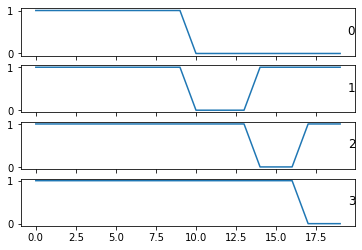

In [ ]:
vals = [0,6,15,20]
intersect, union = {}, {}

for j in range(3):
    pred = x1[vals[j]:vals[j+1]].clone()
    targ = ( x2[vals[j]:vals[j+1]].clone(), )
    targ = targ[0]
    eps = 1e-9
    # pred.shape, targ.shape

    if pred.shape == targ.shape:
        targ = targ.argmax(dim=1)
    n, c = targ.shape[0], pred.shape[1]
    # n, c

    pred = pred.argmax(dim=1).view(n, -1)
    targ = targ.view(n, -1)
    # pred.shape, targ.shape
    # pred.max(), targ.max()
    for i in range(0, c):
        p = torch.where(pred == i, 1, 0)
        t = torch.where(targ == i, 1, 0)
        p, t = TensorBase(p), TensorBase(t)
        c_inter = (p*t).sum(-1).float()#.item()
        c_union = (p+t).sum(-1).float()#.item()
        if i in intersect:
            intersect[i] = torch.cat([intersect[i], c_inter], dim=0)
            union[i]     = torch.cat([union[i], c_union], dim=0)
        else:
            intersect[i] = c_inter
            union[i]     = c_union

binary_dice_scores = np.array([])
for c in intersect.keys():
    cond = union[c] == 0
    val = 2.*(intersect[c]+eps)/(union[c]+eps)
    val[cond] = 1
    binary_dice_scores = np.append(binary_dice_scores, val)

num = 4
fig, axs = plt.subplots(num, 1, sharex=True)
for i in range(num):
    axs[i].plot(binary_dice_scores[(i*20):((i*20)+20)])
    axs[i].set_title(i, loc='right', y=.6, pad=-7.)
print(binary_dice_scores.mean())

In [ ]:
# export
class KaggleDice(Metric):
    """
    Multi-class Dice used in Severstal comp, 
    is 1 when prediction and mask are empty
    """
    def __init__(self, axis=1, eps=1e-9): self.axis, self.eps = axis, eps
    def reset(self): self.inter, self.union = {}, {}
    
    def accumulate(self, learn):
        y = learn.yb[0]
        preds = learn.pred
        
        if preds.shape == y.shape:
            y = y.argmax(dim=self.axis)
            
        n, c = y.shape[0], preds.shape[self.axis]
        
        preds = preds.argmax(dim=self.axis).view(n, -1)
        targs = y.view(n, -1)
        
#         pred, targ = flatten_check(preds, targs)
        for i in range(0, c):
            p = torch.where(preds == i, 1, 0)
            t = torch.where(targs == i, 1, 0)
            
            p, t = TensorBase(p), TensorBase(t)
            
            c_inter = (p*t).sum(-1).float().cpu()#.item()
            c_union = (p+t).sum(-1).float().cpu()#.item()
            if i in self.inter:
                self.inter[i] = torch.cat([self.inter[i], c_inter], dim=0)
                self.union[i] = torch.cat([self.union[i], c_union], dim=0)
            else:
                self.inter[i] = c_inter
                self.union[i] = c_union
                    
    @property
    def value(self):
        binary_dice_scores = np.array([])
        for c in range(len(self.inter)):
            cond = self.union[c] == 0
            val = 2.*(self.inter[c]+self.eps)/(self.union[c]+self.eps)
            val[cond] = 1
            binary_dice_scores = np.append(binary_dice_scores, val.numpy())
        self.binary_dice_scores = binary_dice_scores
        return np.nanmean(binary_dice_scores)

In [ ]:
dice_kaggle_obj = KaggleDice()

In [ ]:
# missing
compute_val(dice_kaggle_obj, pred=preds, y=targs)

0.2071837278086755

In [ ]:
computed_kaggle_dice = compute_val(dice_kaggle_obj, x1, x2)
computed_kaggle_dice_chs = compute_val(dice_kaggle_obj, x1, x2chs)

test_close(computed_kaggle_dice, binary_dice_scores.mean())
test_eq(computed_kaggle_dice, computed_kaggle_dice_chs)

Alternative metric for Kaggle:

In [ ]:
# export
def dice_kaggle(pred: Tensor, targ: Tensor, iou:bool=False, eps:float=1e-8):
    """
    The metric of the competition, 
    if there's no defect in `targ` and no defects in `pred`: dice=1.
    """
    n, c = targ.shape[0], pred.shape[1]
    
    if pred.shape == targ.shape:
        targ = targ.argmax(dim=1)
    
    pred = pred.argmax(dim=1).view(n, -1)
    targ = targ.view(n, -1)

    intersect_list, union_list = [], []
    for i in range(c):
        inp, trgs = TensorBase(pred), TensorBase(targ)
        
        inter = ((inp == i) & (trgs == i)).sum(-1).float()
        un = ((inp == i).sum(-1) + (trgs == i).sum(-1))
        
        intersect_list.append(inter)
        union_list.append(un)

    intersect = torch.stack(intersect_list)
    union = torch.stack(union_list)

    if not iou:
        metric = ((2.0 * intersect + eps) / (union + eps))
    else:
        metric = ((intersect + eps) / (union - intersect + eps))
        
    return metric.mean()

In [ ]:
#missing
tst = AccumMetric(dice_kaggle, flatten=False, dim_argmax=0)
test_close(compute_val(tst, preds, targs), dice_kaggle(preds, targs))

test_close(compute_val(dice_kaggle_obj, preds, targs), 
           compute_val(            tst, preds, targs))

In [ ]:
tst = AccumMetric(dice_kaggle, flatten=False)
test_close(compute_val(tst, x1, x2), dice_kaggle(x1, x2))

tst = AccumMetric(dice_kaggle, flatten=False, dim_argmax=0)
test_close(compute_val(tst, x1, x2chs), dice_kaggle(x1, x2chs))

## Dice

In [ ]:
def dice(outputs:Tensor, targets:Tensor, eps:float=1e-7, threshold:float=None):
    """
    Computes the binary dice metric
    Args:
        outputs (list):  A list of predicted elements
        targets (list): A list of elements that are to be predicted
        eps (float): epsilon
        threshold (float): threshold for outputs binarization
    Returns:
        double:  Dice score
    """
    outputs = F.sigmoid(outputs)

    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

def metric(probability, truth, threshold=0.5):
    """
    Calculates dice of positive and negative images seperately
    `probability` and `truth` must be `torch.Tensors`.
    """
    if isinstance(truth, tuple):
        truth = truth[0]
        
    batch_size = len(truth)
    
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

In [ ]:
#missing
dices, _, _, _, _= metric(preds, targs)
dices.mean()

TensorImage(0.0072)

In [ ]:
# export
def metric(probability, truth, threshold=0.5):
    """
    Calculates dice of positive and negative images seperately
    `probability` and `truth` must be `torch.Tensors`.
    """
    #if isinstance(truth, tuple):
    #    truth = truth[0]
    base_dice_scores, dice_pos_scores, dice_neg_scores = [], [], []
    
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])
        
        base_dice_scores.extend(dice.tolist())
        dice_pos_scores.extend(dice_pos.tolist())
        dice_neg_scores.extend(dice_neg.tolist())
        
        dice     = np.nanmean(base_dice_scores)
        dice_neg = np.nanmean(dice_neg_scores)
        dice_pos = np.nanmean(dice_pos_scores)

    return dice, dice_neg, dice_pos

In [ ]:
#missing
metric(preds, targs, threshold=0.5)

(0.007218837807886303, 0.0, 0.02887535123154521)

In [ ]:
#missing
m = AccumMetric(metric, flatten=False, dim_argmax=0)
compute_val(m, pred=preds, y=targs)

(0.007218837807886303, 0.0, 0.02887535123154521)

In [ ]:
m = AccumMetric(metric, flatten=False, dim_argmax=0)
compute_val(m, pred=x1, y=x2chs)

(0.5, nan, 0.5)

In [ ]:
# export
def epoch_log(epoch_loss, meter):
    """logging the metrics at the end of an epoch"""
    dices = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print(f"Loss: {epoch_loss:.4f} | dice: {dice:.4f} | dice_neg: {dice_neg:.4f} | dice_pos: {dice_pos:.4f}")
    return dice

In [ ]:
epoch_log(0.0, m)

Loss: 0.0000 | dice: 0.5260 | dice_neg: nan | dice_pos: 0.5260


0.5259531036019325

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_metadata.ipynb.
Converted 02_masks.ipynb.
Converted 03_datasets.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_metrics.ipynb.
Converted 06_loss.ipynb.
Converted 07_trainer.ipynb.
Converted 08_predict.ipynb.
Converted 09_visualize.ipynb.
Converted index.ipynb.
